# Spherical grids and UnitConversion


In most applications, Parcels works with `spherical` meshes, where longitude and latitude are given in degrees, while depth is given in meters. But it is also possible to use `flat` meshes, where longitude and latitude are given in meters (note that the dimensions are then still called `longitude` and `latitude` for consistency reasons).

In all cases, velocities are given in m/s. So Parcels seamlessly converts between meters and degrees, under the hood. For transparency, this tutorial explain how this works.


Let's first import the relevant modules, and create dictionaries for the `U`, `V` and `temp` data arrays, with the velocities 1 m/s and the temperature 20C.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_28627/1357681003.py:4: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


In [37]:
from parcels._datasets.structured.generated import simple_UV_dataset
nlat = 10
nlon = 18
ds = simple_UV_dataset(dims=(1, 1, nlat, nlon), mesh="spherical").isel(time=0, depth=0)
ds["temperature"] = ds["U"] + 20 # add temperature field of 20 deg
ds["U"].data[:] = 1.0            # set U to 1 m/s
ds["V"].data[:] = 1.0            # set V to 1 m/s
grid = parcels.XGrid.from_dataset(ds, mesh="spherical")
U = parcels.Field("U", ds["U"], grid, interp_method=parcels.interpolators.XLinear)
V = parcels.Field("V", ds["V"], grid, interp_method=parcels.interpolators.XLinear)
UV = parcels.VectorField("UV", U, V)
temperature = parcels.Field("temperature", ds["temperature"], grid, interp_method=parcels.interpolators.XLinear)
fieldset = parcels.FieldSet([U, V, UV, temperature])

We can convert these data and dims to a FieldSet object using `FieldSet.from_data`. We add the argument `mesh='spherical'` (this is the default option) to signal that all longitudes and latitudes are in degrees.

Plotting the `U` field indeed shows a uniform 1m/s eastward flow.


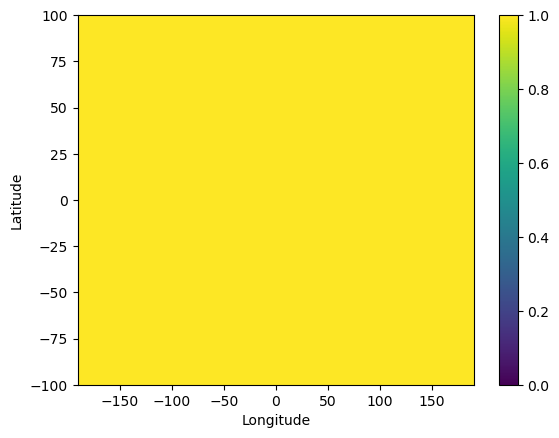

In [38]:
# fieldset = parcels.FieldSet.from_data(data, dims, mesh="spherical")
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, 0, :, :], vmin=0, vmax=1, shading="nearest")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.colorbar()
plt.show()

However, printing the velocites directly shows something perhaps surprising. Here, we use the square-bracket field-interpolation notation to print the field value at (5W, 40N, 0m depth) at time 0. _Note that sampling a velocity in Parcels is done by calling the `fieldset.UV` VectorField; see the [Field Sampling tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html#Sampling-velocity-fields) for more information._


In [39]:
print(fieldset.UV[np.array([0]), np.array([0]), np.array([40]), np.array([-5])])
print(fieldset.temperature[np.array([0]), np.array([0]), np.array([40]), np.array([-5])])

(array([1.17477258e-05]), array([8.99928006e-06]))
[20.]


While the temperature field indeed is 20C, as we defined, these printed velocities are much smaller.

This is because Parcels converts under the hood from m/s to degrees/s. This conversion is done with a `UnitConverter` object, which is stored in the `.units` attribute of each Field. Below, we print these


In [40]:
for fld in [fieldset.U, fieldset.V, fieldset.temperature]:
    print(f"{fld.name}: {fld.units}")

U: <parcels._core.converters.GeographicPolar object at 0x10fef0610>
V: <parcels._core.converters.Geographic object at 0x10fef05d0>
temperature: <parcels._core.converters.UnitConverter object at 0x30a09cc10>


So the U field has a `GeographicPolar` UnitConverter object, the V field has a `Geographic` Unitconverter and the `temp` field has a `UnitConverter` object.

Indeed, if we multiply the value of the V field with 1852 \* 60 (the number of meters in 1 degree of latitude), we get the expected 1 m/s.


In [41]:
u, v = fieldset.UV[np.array([0]), np.array([0]), np.array([40]), np.array([-5])]
print(v * 1852 * 60)

[1.]


Note that you can also interpolate the Field without a unit conversion, by using the `eval()` method and setting `applyConversion=False`, as below


In [43]:
print(fieldset.UV.eval(np.array([0]), np.array([0]), np.array([40]), np.array([-5]), applyConversion=False))

(array([1.]), array([1.]))


## UnitConverters for `mesh='flat'`


If longitudes and latitudes are given in meters, rather than degrees, simply add `mesh='flat'` when creating the FieldSet object.


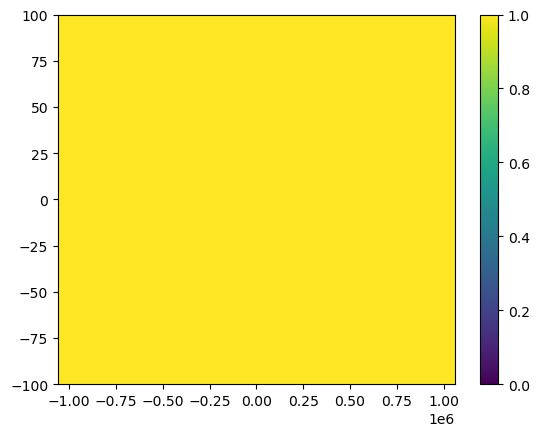

Velocities: (array([1.]), array([1.]))
U: <parcels._core.converters.UnitConverter object at 0x17e88e4d0>
V: <parcels._core.converters.UnitConverter object at 0x309f46310>
temperature: <parcels._core.converters.UnitConverter object at 0x309e22910>


In [49]:
ds = simple_UV_dataset(dims=(1, 1, nlat, nlon), mesh="flat").isel(time=0, depth=0)
ds["temperature"] = ds["U"] + 20 # add temperature field of 20 deg
ds["U"].data[:] = 1.0            # set U to 1 m/s
ds["V"].data[:] = 1.0            # set V to 1 m/s
grid = parcels.XGrid.from_dataset(ds, mesh="flat")
U = parcels.Field("U", ds["U"], grid, interp_method=parcels.interpolators.XLinear)
V = parcels.Field("V", ds["V"], grid, interp_method=parcels.interpolators.XLinear)
UV = parcels.VectorField("UV", U, V)
temperature = parcels.Field("temperature", ds["temperature"], grid, interp_method=parcels.interpolators.XLinear)
fieldset_flat = parcels.FieldSet([U, V, UV, temperature])

plt.pcolormesh(
    fieldset_flat.U.grid.lon,
    fieldset_flat.U.grid.lat,
    fieldset_flat.U.data[0, 0, :, :],
    vmin=0,
    vmax=1,
    shading="nearest"
)
plt.colorbar()
plt.show()

print("Velocities:", fieldset_flat.UV[np.array([0]), np.array([0]), np.array([40]), np.array([-5])])
for fld in [fieldset_flat.U, fieldset_flat.V, fieldset_flat.temperature]:
    print(f"{fld.name}: {fld.units}")

Indeed, in this case all Fields have the same default `UnitConverter` object.


## UnitConverters for Diffusion fields


The units for Brownian diffusion are in $m^2/s$. If (and only if!) the diffusion fields are called "Kh_zonal" and "Kh_meridional", Parcels will automatically assign the correct Unitconverter objects to these fields.


In [52]:
kh_zonal = 100  # in m^2/s
kh_meridional = 100  # in m^2/s

fieldset.add_field(
    parcels.Field(
        "Kh_zonal",
        kh_zonal * np.ones((nlat, nlon), dtype=np.float32),
        grid=fieldset.U.grid,
        interp_method=parcels.interpolators.XLinear
    )
)
fieldset.add_field(
    parcels.Field(
        "Kh_meridional",
        kh_meridional * np.ones((nlat, nlon), dtype=np.float32),
        grid=fieldset.U.grid,
        interp_method=parcels.interpolators.XLinear
    )
)

for fld in [fieldset.Kh_zonal, fieldset.Kh_meridional]:
    print(f"{fld.name}: {fld[np.array([0]), np.array([0]), np.array([40]), np.array([-5])]:e} {fld.units}")

ValueError: Expected `data` to be a uxarray.UxDataArray or xarray.DataArray object, got <class 'numpy.ndarray'>.

Here, the unitconverters are `GeographicPolarSquare` and `GeographicSquare`, respectively.

Indeed, multiplying with $(1852\cdot60)^2$ returns the original value


In [ ]:
deg_to_m = 1852 * 60
print(fieldset.Kh_meridional[0, 0, 40, -5] * deg_to_m**2)

## Adding a UnitConverter object to a Field


So, to summarise, here is a table with all the conversions

| Field name       | Converter object        | Conversion for `mesh='spherical'`                         | Conversion for `mesh='flat'` |
| ---------------- | ----------------------- | --------------------------------------------------------- | ---------------------------- |
| 'U'              | `GeographicPolar`       | $1852 \cdot 60 \cdot \cos(lat \cdot \frac{\pi}{180})$     | 1                            |
| 'V'              | `Geographic`            | $1852 \cdot 60$                                           | 1                            |
| 'Kh_zonal'       | `GeographicPolarSquare` | $(1852 \cdot 60 \cdot \cos(lat \cdot \frac{\pi}{180}))^2$ | 1                            |
| 'Kh_meridional'  | `GeographicSquare`      | $(1852 \cdot 60)^2$                                       | 1                            |
| All other fields | `UnitConverter`         | 1                                                         | 1                            |

Only four Field names are recognised and assigned an automatic UnitConverter object. This means that things might go very wrong when e.g. a velocity field is not called `U` or `V`.

Fortunately, you can always add a UnitConverter later, as explained below:


In [ ]:
fieldset.add_field(
    parcels.Field(
        "Ustokes", np.ones((ydim, xdim), dtype=np.float32), grid=fieldset.U.grid
    )
)
print(fieldset.Ustokes[0, 0, 40, -5])

This value for `Ustokes` of course is not as expected, since the mesh is spherical and hence this would mean 1 degree/s velocity. Assigning the correct `GeographicPolar` Unitconverter gives


In [ ]:
from parcels.tools.converters import GeographicPolar

fieldset.Ustokes.units = GeographicPolar()
print(fieldset.Ustokes[0, 0, 40, -5])
print(fieldset.Ustokes[0, 0, 40, -5] * 1852 * 60 * np.cos(40 * np.pi / 180))